In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import mplfinance as mpf

In [2]:
Estado_resultados=pd.read_excel('FAMSA.xlsx',sheet_name="Estado_resultados")
Balance_general=pd.read_excel('FAMSA.xlsx',sheet_name="Balance_general")
Historico_acciones=pd.read_excel('FAMSA.xlsx',sheet_name="Historico_acciones",index_col="Date")

In [91]:
Estado_resultados=Estado_resultados.dropna(axis=0)
for año in range(2009,2012):
    Estado_resultados.loc[Estado_resultados[año]<0,año]=0
Estado_resultados

,Concepto,2011,2010,2009
0,Costo de ventas,7336.0,7361.0,7355.2
3,Gastos de ventas,6468.5,6325.0,6666.6
9,Otros gastos,0.0,0.0,0.0
18,Resultado Integral de Financiamiento,1315.0,1079.1,1235.6
24,Ventas netas,15294.9,14992.9,14946.9


In [5]:
Balance_general=Balance_general.dropna(axis=0)
Balance_general

,Balances Generales,2011,2010,2009
4,Caja,6.066225e+03,5.433725e+03,4.766925e+03
16,Deudores diversos,1.819868e+04,1.630118e+04,1.430078e+04
23,"Inmuebles, maquinaria y equipo",2.486300e+03,2.561700e+03,2.731900e+03
47,Total Otros activos,1.542500e+03,1.371500e+03,8.048000e+02
50,Total Pasivo a corto plazo,1.513500e+04,1.404860e+04,1.307700e+04
51,Total Pasivo a largo plazo,3.956000e+03,2.633400e+03,1.160100e+03
54,Utilidad neta por acción,2.400000e-01,1.610000e+00,2.200000e-01
55,Número de acciones en circulación,4.394480e+08,4.394480e+08,4.394480e+08


In [13]:
#Razones finaniceras
def razon_corriente(año):
    AC=(Balance_general[año][4]+Balance_general[año][16])
    PC=Balance_general[año][50]
    return AC/PC #Liquidez,Razón corriente


pd.DataFrame({"Prueba":"Razon corirente",2009:[razon_corriente(2009)],2010:[razon_corriente(2010)],2011:[razon_corriente(2011)]})


,Prueba,2009,2010,2011
0,Razon corirente,1.45811,1.547122,1.603231


In [16]:
#ventas/Activo total
def prueb_actividad(año):
    ventas=Estado_resultados[año][24]
    act_to=Balance_general[año][4]+Balance_general[año][16]+Balance_general[año][23]+Balance_general[año][47]
    return ventas/act_to
prueb_actividad(2009),prueb_actividad(2010),prueb_actividad(2011)

(0.661238519934172, 0.5841063421133624, 0.5405761706669683)

In [20]:
def postura1(prueba,cierre): return "Vender" if prueba>cierre else "Comprar"
def posturaRW(valor):return "Comprar" if valor>80 else "Vender" if valor<20 else "Decidir"
def posturaOS(valor):return "Vender" if valor>80 else "Comprar" if valor<20 else "Decidir"
def posturaInVOLNEG(act,fut):return "Comprar" if fut>act else "Vender" 
def postura_On_Balance_Volume(n): return "Comprar" if n>0 else "Vender"

class Empresa:
    def __init__(self,data):
        self.data = data
        self.date=data.index
        self.aper=data.Open
        self.high=data.High
        self.low=data.Low
        self.close=data.Close
        self.vol=data.Volume
    def fecha_close(self):
        return pd.DataFrame({"Fecha":self.date,"Close":self.close})
    
    def media_simple(self):
        lista_simple=[]
        fecha=[]
        for i in range(len(self.close)):
            if (i+5)<=len(self.close):
                lista_simple+=[self.close[i:i+5].mean()]
                fecha+=[self.date[i]]
        return pd.DataFrame({"Fecha":fecha,"Media simple":lista_simple})

    
    def media_expon(self):
        lista_exp=[self.close[0]]
        fecha=[self.date[0]]
        for i in range(1,len(self.close)):
            lista_exp+=[1/3*lista_exp[-1]+(2/3)*self.close[i]]
            fecha+=[self.date[i]]
        return pd.DataFrame({"Fecha":fecha,"Media exponencial":lista_exp}) 
    
    def media_trian(self): #revisar
        lista_gen=[]
        fecha=[]
        for i in range(len(self.close)):
            if (i+5)<=len(self.close):
                lista_gen+=[(self.close[i:i+3].mean()+
                            self.close[i+1:i+4].mean()+
                            self.close[i+2:i+5].mean())/3]
                fecha+=[self.date[i]]

        return pd.DataFrame({"Fecha":fecha,"Media triangular":lista_gen})
    
    def bandas_Bollinger(self):
        central=list(self.media_simple()["Media simple"])
        superior=[]
        inferior=[]
        fecha=[]
        for i in range(len(self.close)):
            if (i+5)<=len(self.close):
                superior+=[self.close[i:i+5].mean()+2*np.std(self.close[i:i+5])]
                inferior+=[self.close[i:i+5].mean()-2*np.std(self.close[i:i+5])]
                fecha+=[self.date[i]]
                
        return pd.DataFrame({"Fecha":fecha,"Central":central,"Superior":superior,"Inferior":inferior})
    
    def MACD(self):
        momentos=[]
        fecha=[]
        for i in range(len(self.close)):
            if (i+26)<=len(self.close):
                momentos+=[self.close[i+14:i+26].mean()-self.close[i:i+26].mean()]
                fecha+=[self.date[i]]
        postura=[postura_On_Balance_Volume(m) for m in momentos]

        return pd.DataFrame({"Fecha":fecha,"Momentos":momentos,"Postura":postura})
    
    def MOMENTO(self):
        momento= [self.close[i+4]-self.close[i] for i in range(len(self.close)) if (i+4)<len(self.close)]
        fecha=[self.date[i] for i in range(len(self.close)) if (i+4)<len(self.close)]
        postura=[postura_On_Balance_Volume(m) for m in momento]
        return pd.DataFrame({"Fecha":fecha,"Momento":momento,"Postura":postura})
    
    def RWilliams(self):
        listaWill=[]
        fecha=[]
        for i in range(len(self.close)):
            if (i+13)<len(self.close):
                num=self.high[i:i+14].max()-self.close[i+13]
                den=self.high[i:i+14].max()-self.low[i:i+14].min()
                fecha+=[self.date[i]]
                if den!=0:
                    listaWill.append((num/den)*100)
                else:
                    listaWill.append("Div entre cero!")
        postura=[posturaRW(n) for n in listaWill]
        return pd.DataFrame({"Fecha":fecha,"%Rwilliams":listaWill,"Postura":postura})
    
    def Oscil_esta(self):
        listOscil=[]
        fecha=[]
        for i in range(len(self.close)):
            if (i+13)<len(self.close):
                num=self.close[i+13]-self.low[i:i+14].min()
                den=self.high[i:i+14].max()-self.low[i:i+14].min()
                fecha+=[self.date[i]]
                if den!=0:
                    listOscil.append((num/den)*100)
                else:
                    listOscil.append(0)
        d=["",""]+[np.mean(listOscil[i:i+3]) for i in range(len(listOscil)) if i+3<=len(listOscil)]
        postura=["",""]+[posturaOS(n) for n in d[2:]]
        return pd.DataFrame({"Fecha":fecha,"%k":listOscil,"%D":d,"Postura":postura})
    
    def ind_vol_neg(self):
        def condin(act,fut): return 1 if fut<act else 0
        lista_indvolneg=[0]
        fecha=[]
        for i in range(1,len(self.vol)-1):
            lista_indvolneg+=[100*((self.close[i+1]/self.close[i])-1)*condin(self.vol[i],self.vol[i+1])+lista_indvolneg[-1]]
            fecha+=[self.date[i]]
        postura=[posturaInVOLNEG(lista_indvolneg[i],lista_indvolneg[i+1]) for i in range(len(lista_indvolneg)-1)]
        return pd.DataFrame({"Fecha":fecha,"índice volumen negativo":lista_indvolneg[1:],"Postura":postura})
    
    def On_Balance_Volume(self):
        lista=[0]
        fecha=[self.date[0]]
        for i in range(1,len(self.vol)):
            if self.close[i-1] == self.close[i]:
                lista+=[lista[-1]]
            else:
                if self.close[i]>self.close[i-1]:
                    lista+=[lista[-1]+self.vol[i]]
                else:
                    lista+=[lista[-1]-self.vol[i]]
            fecha+=[self.date[i]]
        postura=[postura_On_Balance_Volume(n) for n in lista]
        return pd.DataFrame({"Fecha":fecha,"On Balance Volumen":lista,"Postura":postura})
    
    def Línea_de_Distribución(self):
        MFM=[]
        fecha=[]
        for i in range(len(self.close)):
            num=(self.close[i]-self.low[i])-(self.high[i]-self.close[i])
            den=self.high[i]-self.low[i]
            if den!=0:
                MFM.append(num/den)
            else:
                MFM.append(0)
            fecha+=[self.date[i]]
        MFV=[m*v for m,v in zip(MFM,self.vol)]
        postura=[postura_On_Balance_Volume(n) for n in MFV]
        return pd.DataFrame({"Fecha":fecha,"MFM":MFM,"MFV":MFV,"Postura":postura})
            
    def Oscilador_Chaikin(self):
        mmexp=[self.Línea_de_Distribución()["MFV"][0]]
        mmexp2=[self.Línea_de_Distribución()["MFV"][0]]
        fecha=[self.date[0]]
        for x in range(1,len(self.Línea_de_Distribución()["MFV"])):
            mmexp.append(0.5*(mmexp[-1]+self.Línea_de_Distribución()["MFV"][x]))
            fecha+=[self.date[x]]
        for x in range(1,len(self.Línea_de_Distribución()["MFV"])):
            mmexp2.append(mmexp2[-1]*9/11+2/11*self.Línea_de_Distribución()["MFV"][x])
        difs=[a-b for a,b in zip(mmexp,mmexp2)]
        postura=[postura_On_Balance_Volume(n) for n in difs]
        

        return pd.DataFrame({"Fecha":fecha,"mmexp(LDA)3t":mmexp,"mmexp(LDA)10t":mmexp2,"exp":difs,"Postura":postura})
        
                    
Famsa=Empresa(Historico_acciones[::-1])


In [18]:
def dic_postura(data_frame,colum):
    dic_aux=pd.merge(Famsa.fecha_close(),data_frame,on="Fecha")
    postura=[]
    for c,m in zip(dic_aux.Close,dic_aux[colum]):
        postura.append(postura1(m,c))
    dic_aux["Postura"]=postura
    return dic_aux

In [24]:
#media simple
writer = pd.ExcelWriter('Pruebas Financieras.xlsx')
Media_simp=dic_postura(Famsa.media_simple(),"Media simple")
Media_simp.to_excel(writer, sheet_name="Media simple", index=False)
# writer.save()
# writer.close()

In [25]:
def agregar_hoja(DataF,nombre):
    DataF.to_excel(writer,sheet_name=nombre,index=False)
    

In [27]:
agregar_hoja(dic_postura(Famsa.media_expon(),"Media exponencial"),"Media exponencial")

In [28]:
#Media triangular
agregar_hoja(dic_postura(Famsa.media_trian(),'Media triangular'),"Media triangular")

In [29]:
#MACD
agregar_hoja(Famsa.MACD(),"MACD")

In [30]:
#Momento
agregar_hoja(Famsa.MOMENTO(),"MOMENTO")

In [31]:
#R williams
agregar_hoja(Famsa.RWilliams(),"R williams")

In [32]:
#Oscilador estocástico
agregar_hoja(Famsa.Oscil_esta(),"Oscilador estocástico")

In [33]:
#índice volumen negativo
agregar_hoja(Famsa.ind_vol_neg(),"índice volumen negativo")

In [34]:
#On Balance Volumen
agregar_hoja(Famsa.On_Balance_Volume(),"On Balance Volumen")

In [35]:
#Línea_de_Distribución
agregar_hoja(Famsa.Línea_de_Distribución(),"Linea de distribución")

In [36]:
#Oscilador Chaikin
agregar_hoja(Famsa.Oscilador_Chaikin(),"Oscilador chaikin")

In [37]:
writer.save()
writer.close()

C:\Users\leona\AppData\Local\Continuum\anaconda3\lib\site-packages\mplfinance\_arg_validators.py:46: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  category=UserWarning)


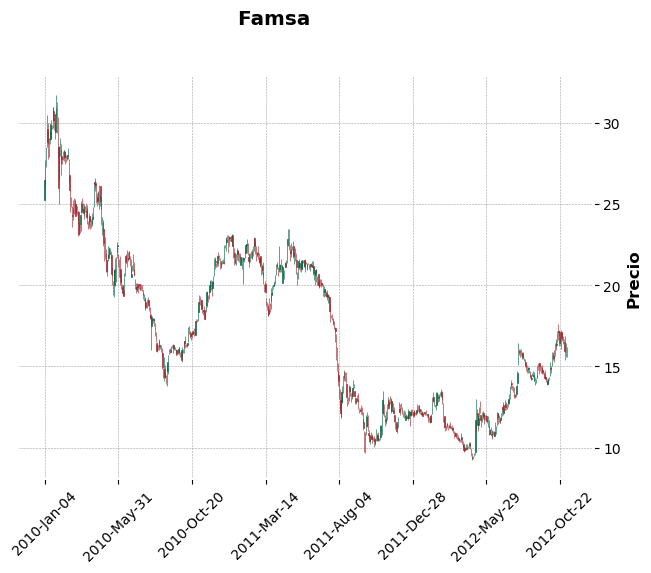

In [19]:
mpf.plot(Historico_acciones[::-1],type='candle',style="charles",title="Famsa",ylabel="Precio")

In [20]:
def grafico_velas(a,b):
    return mpf.plot(Historico_acciones[a:b:-1],type='candle',style="charles",title="Famsa",ylabel="Precio")

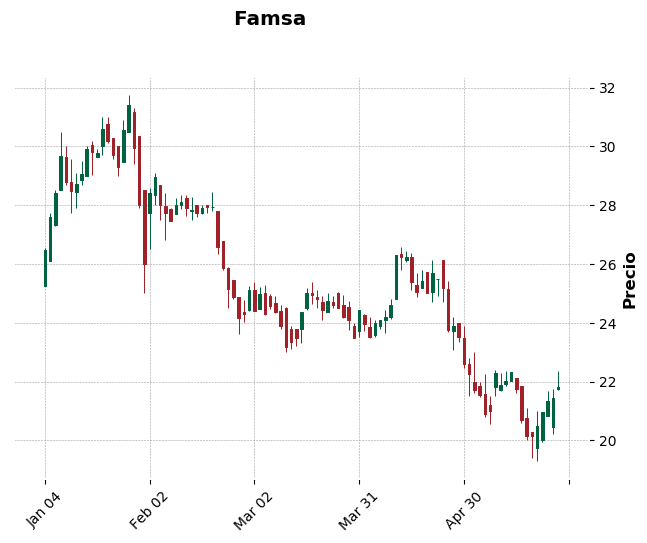

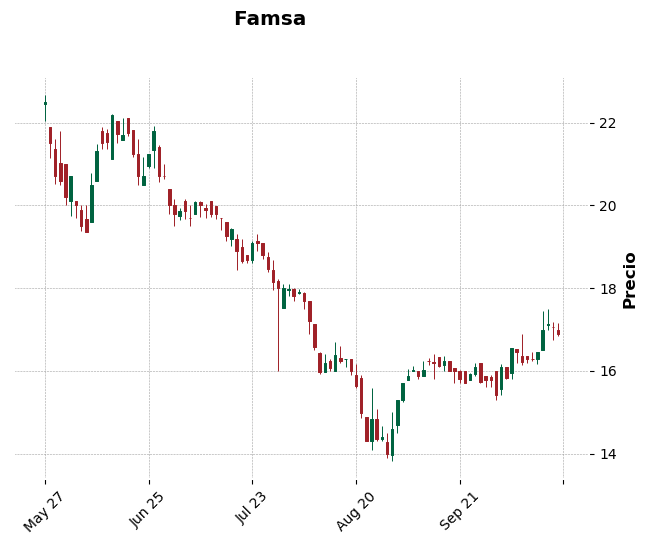

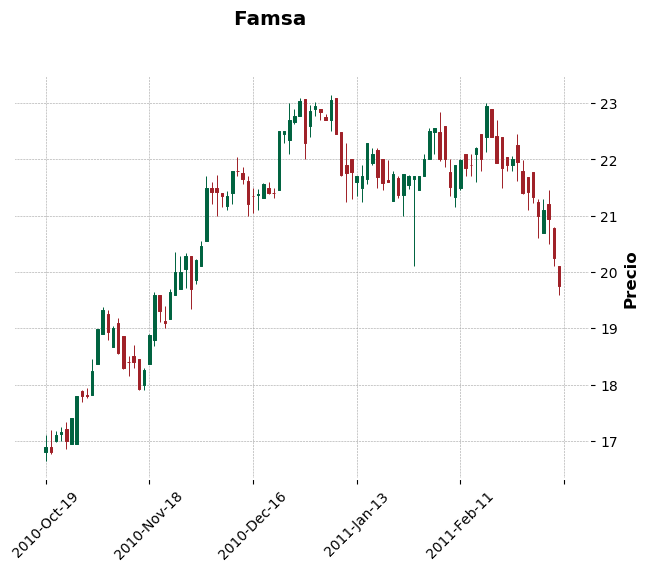

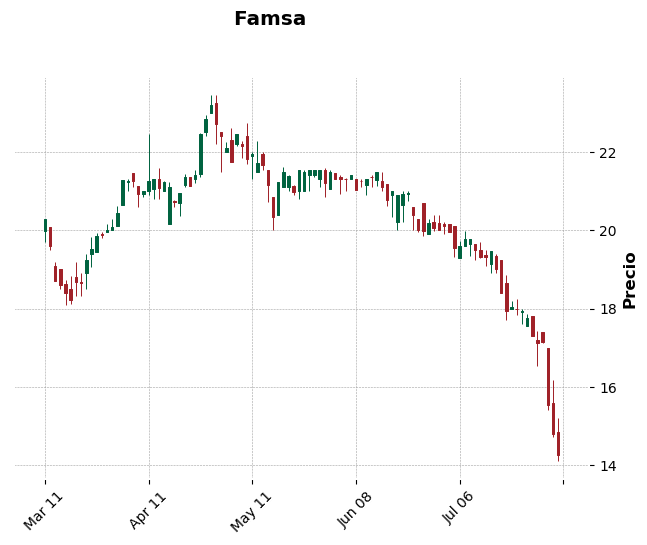

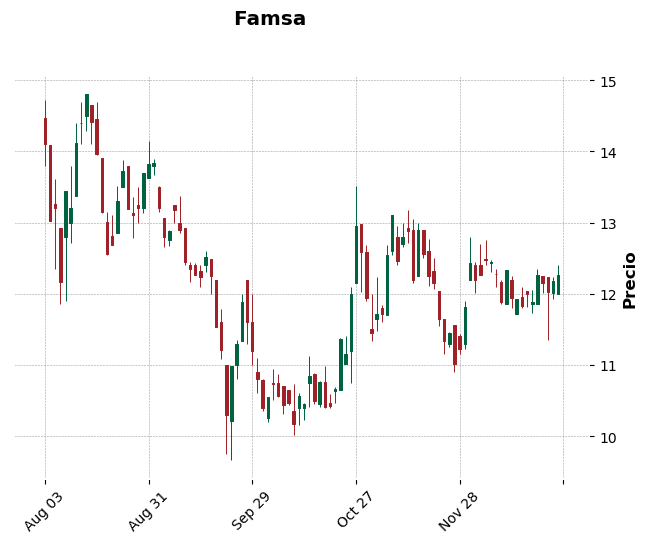

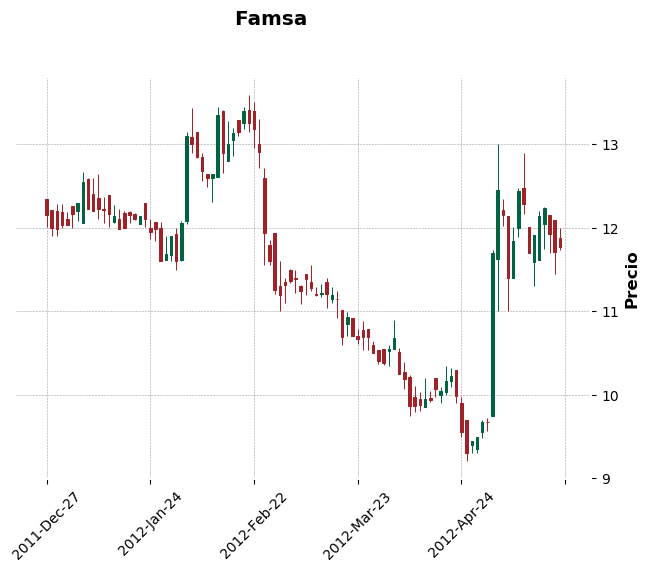

In [21]:
for x in range(len(Historico_acciones),110,-100):
    grafico_velas(x,x-100)


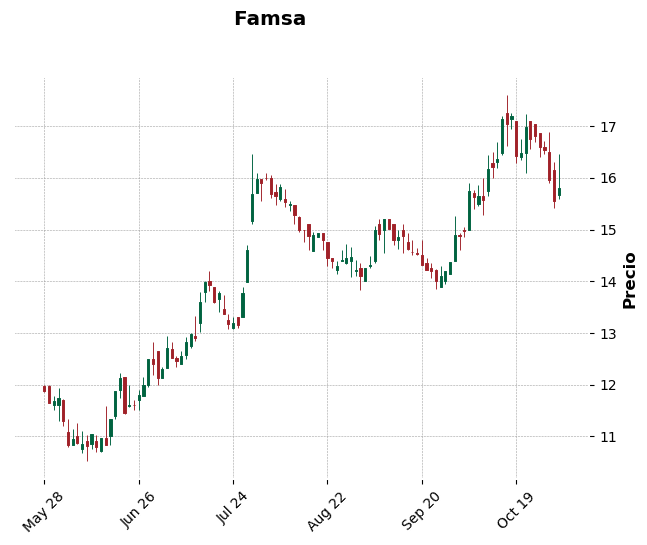

In [124]:
grafico_velas(110,0)

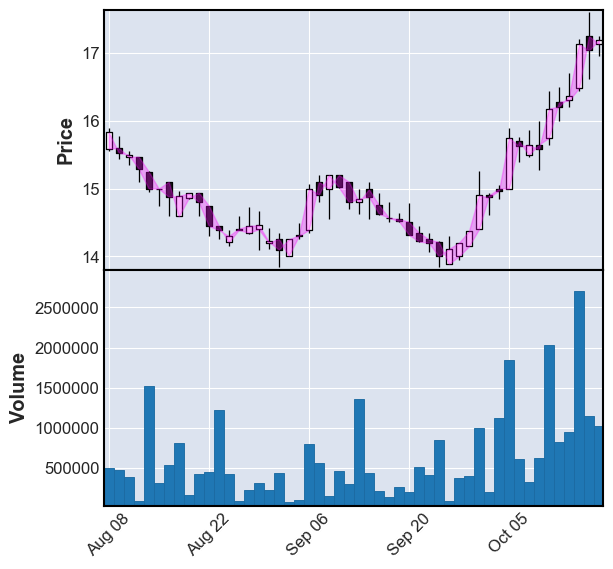

In [38]:
fb1 = dict(y1=Historico_acciones[60:10:-1]['Open'].values  , y2=Historico_acciones[60:10:-1]['Close'].values , panel=0, alpha=0.3, color='magenta')
mpf.plot(Historico_acciones[60:10:-1],volume=True,panel_ratios=(1.1,1),
         type='candle',tight_layout=True,figratio=(1,1),
         fill_between=[fb1])




# Graficas

In [95]:
def graficalin(col,rgba):
    plt.title(col)
    plt.plot(Historico_acciones[col],color=rgba)
    plt.xticks(rotation=45)
    plt.xlabel("Fecha")
    plt.ylabel("Precio")
    plt.grid(0)
    plt.show()
def graficabar(col,rgba):
    plt.title(col)
    plt.hist(Historico_acciones[col],color=rgba)
    plt.xlabel("Fecha")
    plt.ylabel("Precio")
    plt.show()

In [96]:
colores=["#3DE380","#A3C9F6","#B70D3D","#D84BEE","#E6EB90"]

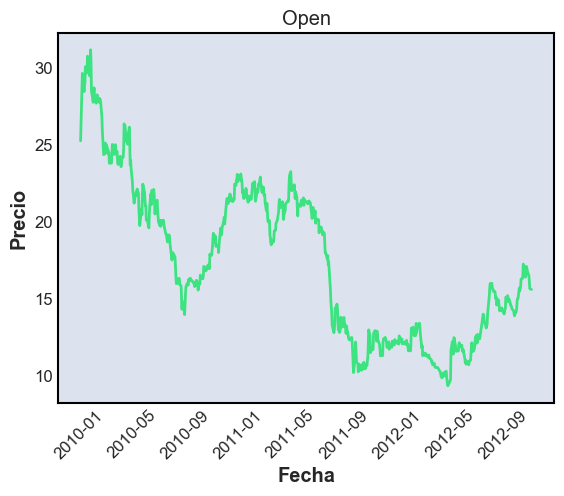

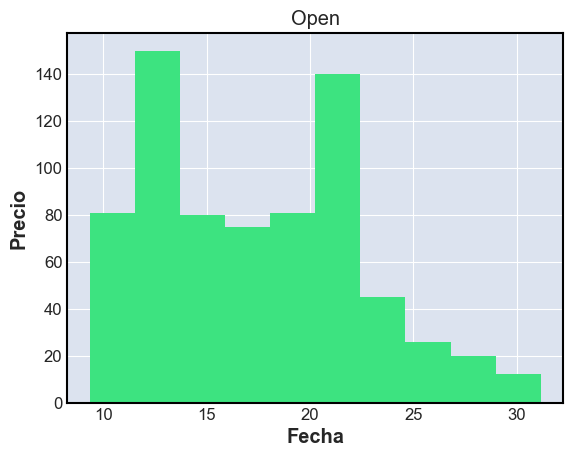

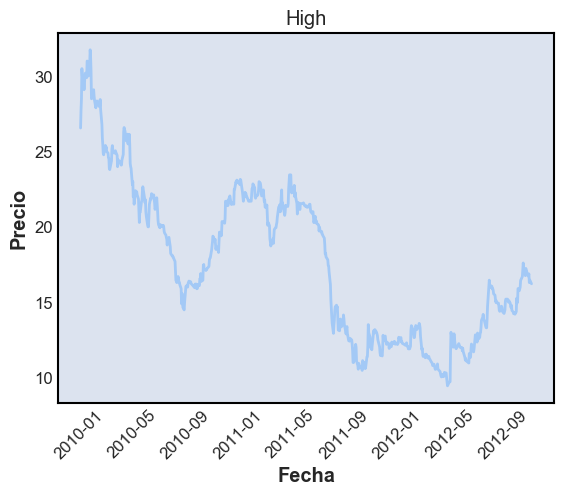

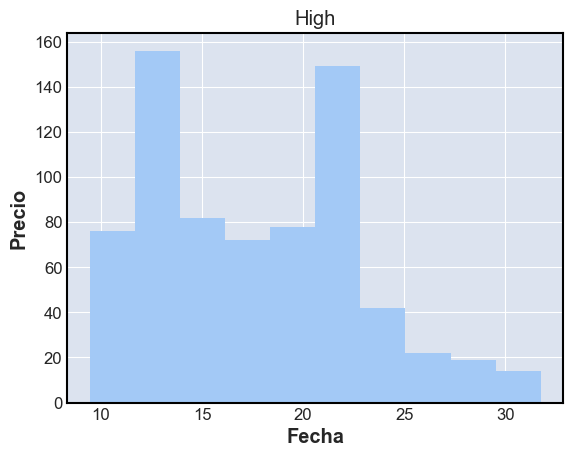

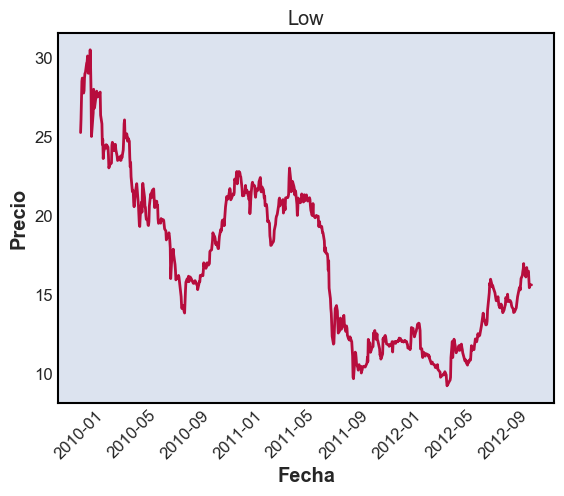

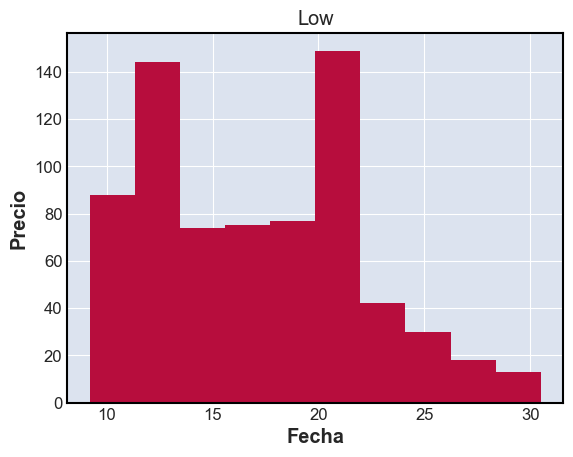

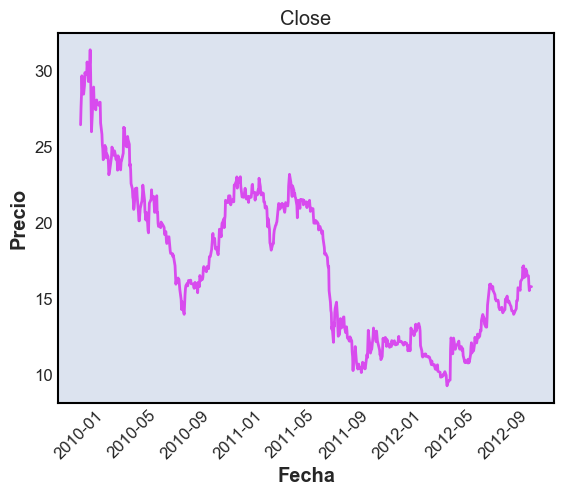

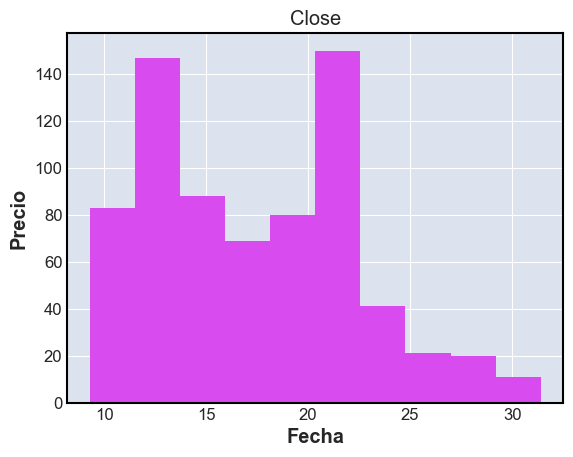

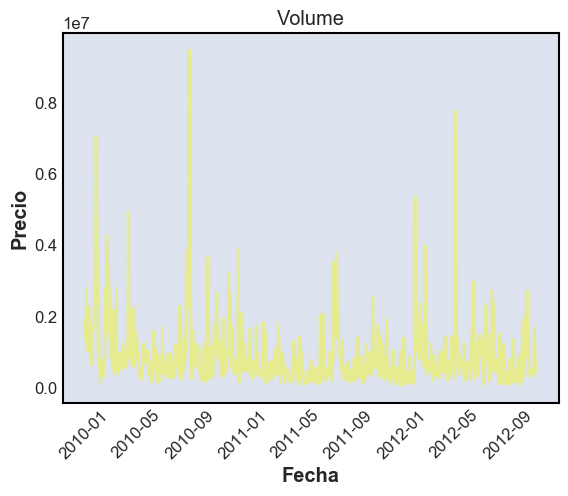

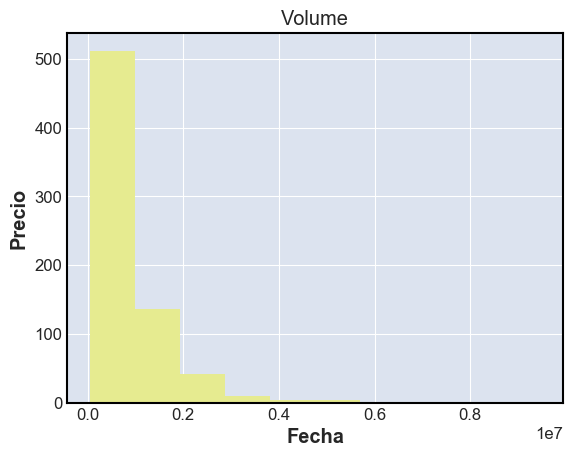

In [97]:
for c,r in zip(Historico_acciones.columns,colores):
    graficalin(c,r)
    graficabar(c,r)

In [113]:
import statsmodels.api as sm


model = sm.OLS(Historico_acciones[::-1].index,Historico_acciones[::-1]['Close']).fit()


In [119]:
model.params[0]

6.893040430214557e+16

In [122]:
6893040430214557


6893040430214557